#### CSC 296S Deep Learning (Spring 2026)

#### Dr. Haiquan Chen, Dept of Computer Scicence

#### California State University, Sacramento



## Imports & Functions

In [18]:
#inport statements

import os
import tensorflow as tf
import sys
import sklearn as sk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, roc_auc_score
#testing variables, set True for more in depth results
testing = False
testingResults = False

In [2]:
#This is a function that returns x as an average for each field for x and the final sepsis value as y.  However, I believe window size is better
#EX:
# 0 0 0 | 0
# 0 1 2 | 1
#Becomes:
# 0 0.5 1 | 1

'''#modify the data
preparedPatients = []
for i in range (1,6001):
    temp = patients[f"p{i:06d}"]
    #drop unneccessary fields
    temp.drop(['Bilirubin_direct', 'Bilirubin_total', 'TroponinI', 'Fibrinogen', 'Unit1', 'Unit2', 'EtCO2'], axis=1, inplace=True)
    row = temp.mean() #using the average per patient if applicatble
    row = row.fillna(global_means) #if average can't be calculated per patient, use global average
    row['SepsisLabel'] = temp['SepsisLabel'].iloc[-1] #overwrite sepsis label with last label 
    
    preparedPatients.append(row)

#store as a dataframe
df_patients = pd.DataFrame(preparedPatients)

#xy split (not using to_xy)
y = df_patients['SepsisLabel'].values.astype(np.float32) 
x = df_patients.drop('SepsisLabel', axis=1).values.astype(np.float32)
'''

# calculate the global standard deviations (similar to encode numeric zscore)
def calc_global_stds(df, replace_zeros=True):
    stds = df.std()
    if replace_zeros:
        stds = stds.replace(0, 1)  #avoid division by zero for constant columns
    return stds


## Load In The Data

In [3]:
#considering that there are many more patients without sepsis than with sepsis,
#it will help balance results to get every instance of sepsis

#get every instance of patient with sepsis in both datasets, put in a library
patients = {}
j = 1

#dataset A
for i in range (0,20644):
    try:
        filename = f"CC-2019-Sepsis/training_setA/p{i:06d}.psv"
        temp = pd.read_csv(filename, sep='|')
        #if the patient has sepsis, store in library
        if temp['SepsisLabel'].iloc[-1] == 1:
            key = f"p{j:06d}"
            patients[key] = temp
            j += 1
    except FileNotFoundError as e:
        if testing == True:
            print(f"file not found p{i}.psv")
        
#dataset B
for i in range (100000,120001):
    try:
        filename = f"CC-2019-Sepsis/training_setB/p{i:06d}.psv"
        temp = pd.read_csv(filename, sep='|')
        #if the patient has sepsis, store in library
        if temp['SepsisLabel'].iloc[-1] == 1:
            key = f"p{j:06d}"
            patients[key] = temp
            j += 1
    except FileNotFoundError as e:
        if testing == True:
            print(f"file not found p{i}.psv")
        
#number of sepsis patients found        
numSepsisPatients = (len(patients))

#add in non sepsis patients from dataset A for a total of 6000
for i in range (0,20643):
    if j > 6000:
        break
    try:
        filename = f"CC-2019-Sepsis/training_setA/p{i:06d}.psv"
        temp = pd.read_csv(filename, sep='|')
        if temp['SepsisLabel'].iloc[-1] == 0:
            key = f"p{j:06d}"
            patients[key] = temp
            j += 1
    except FileNotFoundError as e:
        if testing == True:
            print(f"file not found p{i}.psv")

## Data Preparation

In [4]:
#get the global average for all data

all_dfs = []
#dataset A
for i in range(0, 20644):
    try:
        filename = f"CC-2019-Sepsis/training_setA/p{i:06d}.psv"
        temp = pd.read_csv(filename, sep='|')
        all_dfs.append(temp)
    except FileNotFoundError:
        if testing == True:
            print(f"file not found p{i}.psv")
#dataset B
for i in range (100000,120001):
    try:
        filename = f"CC-2019-Sepsis/training_setB/p{i:06d}.psv"
        temp = pd.read_csv(filename, sep='|')
        all_dfs.append(temp)
    except FileNotFoundError as e:
        if testing == True:
            print(f"file not found p{i}.psv")
global_df = pd.concat(all_dfs, ignore_index=True)
global_means = global_df.mean()
global_stds = calc_global_stds(global_df)

In [5]:
#view the calculated means & current number of patients loaded in
if testingResults == True:
    print(global_means)
    print(f"number of sepsis patients: {numSepsisPatients}")
    print(f"total number of patients: {len(patients)}")

In [6]:
#checkout x and y values for patient 1
if testingResults == True:
    print(x[1])
    print(y[1])

In [7]:
#test script to find the biggest window size we can have without padding (it's 8)
if testing == True:
    min_rows = float('inf')
    min_file = None

    for i in range(0, 20644):
        try:
            filename = f"CC-2019-Sepsis/training_setA/p{i:06d}.psv"
            temp = pd.read_csv(filename, sep='|')
            if len(temp) < min_rows:
                min_rows = len(temp)
                min_file = f"p{i:06d}"
        except FileNotFoundError:
            pass

    print(f"Smallest file: {min_file} with {min_rows} rows")
    for i in range (100000,120001):
        try:
            filename = f"CC-2019-Sepsis/training_setB/p{i:06d}.psv"
            temp = pd.read_csv(filename, sep='|')
            if len(temp) < min_rows:
                min_rows = len(temp)
                min_file = f"p{i:06d}"
        except FileNotFoundError:
            pass

    print(f"Smallest file: {min_file} with {min_rows} rows")

In [8]:
#define how many time entries per patient
WINDOW_SIZE = 8 
#columns to be dropped
DROP_COLS = ['Bilirubin_direct', 'Bilirubin_total', 'TroponinI', 'Fibrinogen', 'Unit1', 'Unit2', 'EtCO2', 'SepsisLabel']

preparedPatients = []
labels = []

for i in range(1, 6001):
    temp = patients[f"p{i:06d}"]
    temp = temp.drop(DROP_COLS, axis=1) #drop unneccessary fields and SepsisLabel
    temp = temp.fillna(global_means) #fill NaNs with global means
    
    feat_cols = temp.columns
    temp = (temp - global_means[feat_cols]) / global_stds[feat_cols]
    
    #pad with global mean values for each column if patient has fewer than WINDOW_SIZE rows
    if len(temp) < WINDOW_SIZE:
        padding = pd.DataFrame(
            np.zeros((WINDOW_SIZE - len(temp), len(feat_cols))),
            columns=feat_cols
        )
        temp = pd.concat([temp, padding], ignore_index=True)
    
    #take WINDOW_SIZE rows from end and flatten to 1D
    window = temp.iloc[-WINDOW_SIZE:].values.astype(np.float32)
    preparedPatients.append(window.flatten())
    
    #overwrite sepsis label with last label 
    labels.append(patients[f"p{i:06d}"]['SepsisLabel'].iloc[-1])

#set x and y values (not using to_xy())
x = np.array(preparedPatients, dtype=np.float32)
y = np.array(labels, dtype=np.float32)

In [9]:
#view the shape of x and y values as well as values for first entry of x
if testingResults == True:
    print(f"x shape: {x.shape}\ny shape: {y.shape}")
    print(f"values for first entry of x: {x[1]}")

In [10]:
#train test split, 80/20 split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42, shuffle=True)

In [11]:
#contrast original dataframe sizes with split dataframe sizes
if testingResults == True:
    print(f"x_test shape: {x_test.shape}\nx_train shape: {x_train.shape}")
    print(f"y_test shape: {y_test.shape}\ny_train shape: {y_train.shape}")

## Some notes
-The data is now cleaned, split into x/y and then split into train/test for both x and y<br><br>
-The approach is to take out a window size from each file (first 8 entries) to use as x, filling in NaN values with either the local or global mean<br><br>
-The y value is the final SepsisLabel in the dataset, as that value will tell us if the patient had sepsis or not<br><br>
-This approach lines up very well with EC 4, as the window size functionality is already implemented.  Padding has also been implemented if necessary to test window sizes greater than 8 (the smallest files only have 8 time entries)<br><br>
-The data chosen specifically brings in ALL instances of sepsis patients from both datasets (roughly 2900) and pairs it with a similar amount of non sepsis patients (roughly 3100).  This technically could qualify as undersampling the non-sepsis data, which would fulfull EC 1 if we wanted to contrast it with an additional method of reading in the data that just takes the first 6000 entries instead of scanning for specific entries.  That being said, if there was some other EC you would rather do instead let me know<br><br>
-Ensure you put the unzipped data file CC-2019-Sepsis in the same directory as CSC296SProj1.ipynb<br><br>
-At this stage, assuming there are no bugs the data should be ready to be put into some models!

## Running Models

#first model to test data preproc is working (taken from a previous project)
    #-----------------------------------------------------------------
    #NOTE: change verbose to 1 on model.fit for a more detailed report
    #-----------------------------------------------------------------

checkpointer = ModelCheckpoint("fcn-best_weights.keras", verbose=0, save_best_only=True)
best_val_loss = float('inf')
best_model = None
for i in range(5):
    print(f"training FCN: {i}")
    model = Sequential()
    model.add(Dense(64, input_dim=x_train.shape[1], activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(8, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=SGD(learning_rate=0.001, momentum=0.01), metrics=['accuracy'])
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=2, mode='min', restore_best_weights=True)    
    history = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=64, callbacks=[monitor, checkpointer], verbose=0, epochs=10000)

    #track best model across runs by val loss
    val_loss = min(history.history['val_loss'])
    print(f"  Run {i} best val loss: {val_loss:.4f}")
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model
        print(f"  New best model (val loss: {best_val_loss:.4f})")

#evaluation
print("\n--- Final Evaluation on Test Set ---")
y_pred_prob = best_model.predict(x_test)
y_pred = (y_pred_prob >= 0.5).astype(int).flatten()
print(classification_report(y_test, y_pred, target_names=['No Sepsis', 'Sepsis']))
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_prob):.4f}")

# Simeon

## Basic model

Epoch 1/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5015 - loss: 0.7370 - val_accuracy: 0.5183 - val_loss: 0.6785
Epoch 2/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5164 - loss: 0.7155 - val_accuracy: 0.5267 - val_loss: 0.6759
Epoch 3/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5173 - loss: 0.7197 - val_accuracy: 0.5317 - val_loss: 0.6741
Epoch 4/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5248 - loss: 0.7104 - val_accuracy: 0.5442 - val_loss: 0.6727
Epoch 5/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5139 - loss: 0.7054 - val_accuracy: 0.5583 - val_loss: 0.6717
Epoch 6/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5241 - loss: 0.7018 - val_accuracy: 0.5658 - val_loss: 0.6709
Epoch 7/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5450 - loss: 0.6948 - val_accuracy: 0.5792 - val_loss: 0.6702
Epoch 8/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5224 - loss: 0.7094 - val_accu

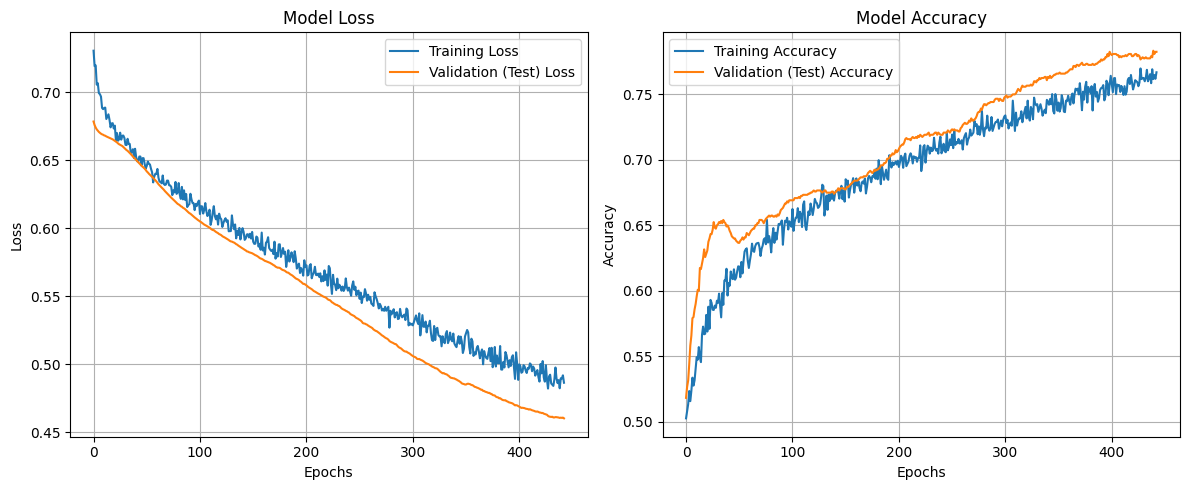

In [22]:
checkpointer = ModelCheckpoint("model_2_fcn-best_weights.keras", verbose=0, save_best_only=True)
best_val_loss = float('inf')
best_model = None


model = Sequential()
model.add(Dense(64, input_dim=x_train.shape[1], activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=SGD(learning_rate=0.001, momentum=0.01), metrics=['accuracy'])
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=2, mode='min', restore_best_weights=True)
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=64, callbacks=[monitor, checkpointer], verbose=1, epochs=10000)

#track best model across runs by val loss
val_loss = min(history.history['val_loss'])
print(f"  Run val loss: {val_loss:.4f}")
if val_loss < best_val_loss:
    best_val_loss = val_loss
    best_model = model
    print(f"  New best model (val loss: {best_val_loss:.4f})")

#evaluation
print("\n--- Final Evaluation on Test Set ---")
y_pred_prob = best_model.predict(x_test)
y_pred = (y_pred_prob >= 0.5).astype(int).flatten()
print(classification_report(y_test, y_pred, target_names=['No Sepsis', 'Sepsis']))
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_prob):.4f}")



plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation (Test) Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation (Test) Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## Since it takes a lot of epochs to learn, reduce the layers, remove dropout, change dropout to 0.2

Epoch 1/10000


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5540 - loss: 0.7007 - val_accuracy: 0.5417 - val_loss: 0.7028
Epoch 2/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5449 - loss: 0.6966 - val_accuracy: 0.5533 - val_loss: 0.6966
Epoch 3/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5817 - loss: 0.6778 - val_accuracy: 0.5533 - val_loss: 0.6915
Epoch 4/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5572 - loss: 0.6875 - val_accuracy: 0.5575 - val_loss: 0.6873
Epoch 5/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5827 - loss: 0.6728 - val_accuracy: 0.5592 - val_loss: 0.6835
Epoch 6/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5755 - loss: 0.6733 - val_accuracy: 0.5592 - val_loss: 0.6801
Epoch 7/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5922 - loss: 0.6708 - val_accuracy: 0.5608 - val_loss: 0.6770
Epoch 8/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5748 - loss: 0.6669 - val_accuracy: 0.5575 -

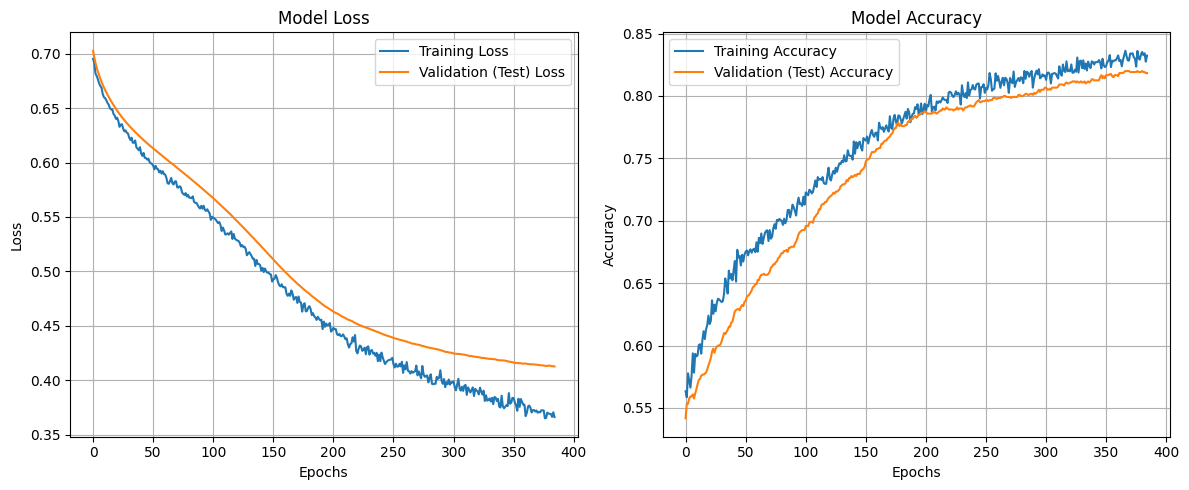

In [24]:
checkpointer = ModelCheckpoint("model_less_layer_fcn-best_weights.keras", verbose=0, save_best_only=True)
best_val_loss = float('inf')
best_model = None


model = Sequential()
model.add(Dense(64, input_dim=x_train.shape[1], activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=SGD(learning_rate=0.001, momentum=0.01), metrics=['accuracy'])
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=2, mode='min', restore_best_weights=True)
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=64, callbacks=[monitor, checkpointer], verbose=1, epochs=10000)

#track best model across runs by val loss
val_loss = min(history.history['val_loss'])
print(f"  Run val loss: {val_loss:.4f}")
if val_loss < best_val_loss:
    best_val_loss = val_loss
    best_model = model
    print(f"  New best model (val loss: {best_val_loss:.4f})")

#evaluation
print("\n--- Final Evaluation on Test Set ---")
y_pred_prob = best_model.predict(x_test)
y_pred = (y_pred_prob >= 0.5).astype(int).flatten()
print(classification_report(y_test, y_pred, target_names=['No Sepsis', 'Sepsis']))
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_prob):.4f}")


plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation (Test) Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation (Test) Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## less neurons, leaky relu


In [25]:
from tensorflow.keras.layers import LeakyReLU

Epoch 1/10000


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4600 - loss: 0.7409 - val_accuracy: 0.4883 - val_loss: 0.7246
Epoch 2/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step - accuracy: 0.4706 - loss: 0.7303 - val_accuracy: 0.4967 - val_loss: 0.7152
Epoch 3/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step - accuracy: 0.4899 - loss: 0.7192 - val_accuracy: 0.5042 - val_loss: 0.7092
Epoch 4/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step - accuracy: 0.4828 - loss: 0.7133 - val_accuracy: 0.5075 - val_loss: 0.7048
Epoch 5/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step - accuracy: 0.5077 - loss: 0.7076 - val_accuracy: 0.5125 - val_loss: 0.7015
Epoch 6/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step - accuracy: 0.4993 - loss: 0.7044 - val_accuracy: 0.5208 - val_loss: 0.6989
Epoch 7/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step - accuracy: 0.4983 - loss: 0.7001 - val_accuracy: 0.5267 - val_loss: 0.6968
Epoch 8/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4968 - loss: 0.7010 - val_accura

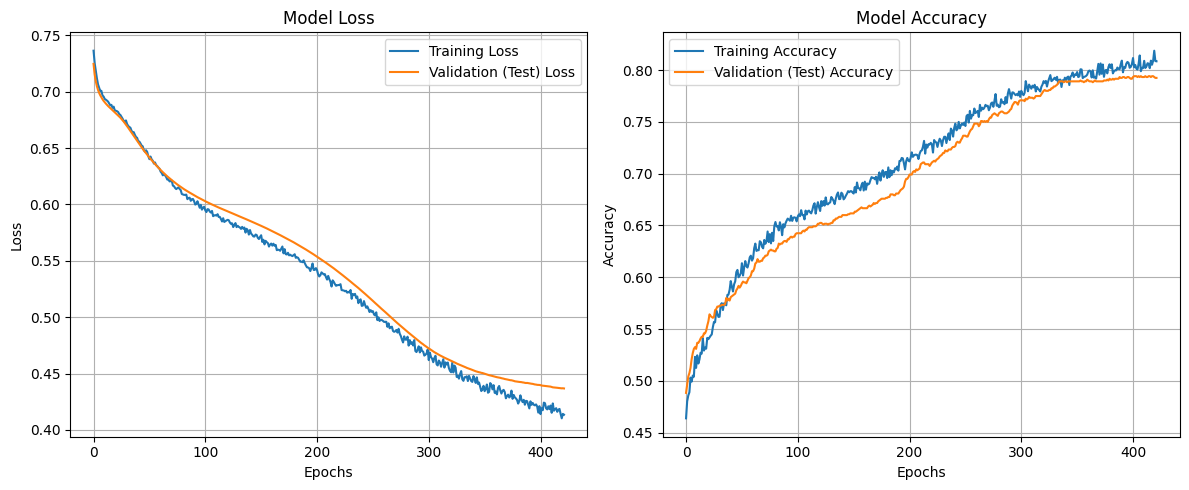

In [27]:
checkpointer = ModelCheckpoint("model_layer_leakyRelu_learning_fcn-best_weights.keras", verbose=0, save_best_only=True)
best_val_loss = float('inf')
best_model = None


model = Sequential()
model.add(Dense(32, input_dim=x_train.shape[1]))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.2))

model.add(Dense(16))
model.add(LeakyReLU(alpha=0.1))

model.add(Dense(8))
model.add(LeakyReLU(alpha=0.1))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=SGD(learning_rate=0.001, momentum=0.01), metrics=['accuracy'])
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=2, mode='min', restore_best_weights=True)
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=64, callbacks=[monitor, checkpointer], verbose=1, epochs=10000)

#track best model across runs by val loss
val_loss = min(history.history['val_loss'])
print(f"  Run val loss: {val_loss:.4f}")
if val_loss < best_val_loss:
    best_val_loss = val_loss
    best_model = model
    print(f"  New best model (val loss: {best_val_loss:.4f})")

#evaluation
print("\n--- Final Evaluation on Test Set ---")
y_pred_prob = best_model.predict(x_test)
y_pred = (y_pred_prob >= 0.5).astype(int).flatten()
print(classification_report(y_test, y_pred, target_names=['No Sepsis', 'Sepsis']))
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_prob):.4f}")


plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation (Test) Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation (Test) Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Epoch 1/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5197 - loss: 1.1085 - val_accuracy: 0.4975 - val_loss: 0.9619
Epoch 2/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step - accuracy: 0.5136 - loss: 0.9229 - val_accuracy: 0.4908 - val_loss: 0.8382
Epoch 3/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step - accuracy: 0.5239 - loss: 0.8163 - val_accuracy: 0.5167 - val_loss: 0.7724
Epoch 4/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step - accuracy: 0.5391 - loss: 0.7655 - val_accuracy: 0.5383 - val_loss: 0.7347
Epoch 5/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5723 - loss: 0.7133 - val_accuracy: 0.5642 - val_loss: 0.7118
Epoch 6/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step - accuracy: 0.5713 - loss: 0.7057 - val_accuracy: 0.5642 - val_loss: 0.6962
Epoch 7/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step - accuracy: 0.5725 - loss: 0.6940 - val_accuracy: 0.5692 - val_loss: 0.6854
Epoch 8/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step - accuracy: 0.5944 - loss: 0.677

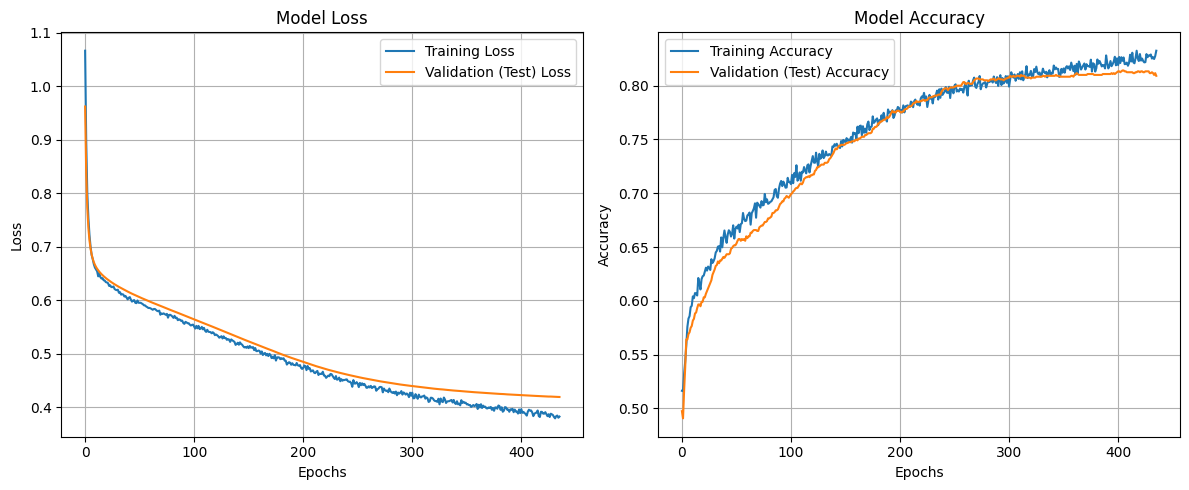

In [31]:
checkpointer = ModelCheckpoint("model_5_fcn-best_weights.keras", verbose=0, save_best_only=True)
best_val_loss = float('inf')
best_model = None


model = Sequential()
model.add(Dense(64, input_dim=x_train.shape[1]))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.2))

model.add(Dense(32))
model.add(LeakyReLU(alpha=0.1))

#model.add(Dense(32))
#model.add(LeakyReLU(alpha=0.1))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=SGD(learning_rate=0.001, momentum=0.01), metrics=['accuracy'])
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=2, mode='min', restore_best_weights=True)
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=64, callbacks=[monitor, checkpointer], verbose=1, epochs=10000)

#track best model across runs by val loss
val_loss = min(history.history['val_loss'])
print(f"  Run val loss: {val_loss:.4f}")
if val_loss < best_val_loss:
    best_val_loss = val_loss
    best_model = model
    print(f"  New best model (val loss: {best_val_loss:.4f})")

#evaluation
print("\n--- Final Evaluation on Test Set ---")
y_pred_prob = best_model.predict(x_test)
y_pred = (y_pred_prob >= 0.5).astype(int).flatten()
print(classification_report(y_test, y_pred, target_names=['No Sepsis', 'Sepsis']))
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_prob):.4f}")


plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation (Test) Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation (Test) Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


use learning decay? on model.compile(loss='binary_crossentropy', optimizer=SGD(learning_rate=0.001, momentum=0.01), metrics=['accuracy'])

## Model 2 remains the best - normal relu

- start with bigger learning rate and heavier momentum to "roll" better through the loss landscape without getting stuck easily
- learning rate reduce on plateau

In [42]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

Epoch 1/10000


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4827 - loss: 0.7674 - val_accuracy: 0.5008 - val_loss: 0.6874 - learning_rate: 0.0100
Epoch 2/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step - accuracy: 0.5475 - loss: 0.6791 - val_accuracy: 0.5342 - val_loss: 0.6629 - learning_rate: 0.0100
Epoch 3/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step - accuracy: 0.5752 - loss: 0.6541 - val_accuracy: 0.5808 - val_loss: 0.6433 - learning_rate: 0.0100
Epoch 4/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step - accuracy: 0.6219 - loss: 0.6377 - val_accuracy: 0.6133 - val_loss: 0.6275 - learning_rate: 0.0100
Epoch 5/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6519 - loss: 0.6156 - val_accuracy: 0.6267 - val_loss: 0.6147 - learning_rate: 0.0100
Epoch 6/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step - accuracy: 0.6667 - loss: 0.6056 - val_accuracy: 0.6367 - val_loss: 0.6049 - learning_rate: 0.0100
Epoch 7/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6773 - loss: 0.5908 -

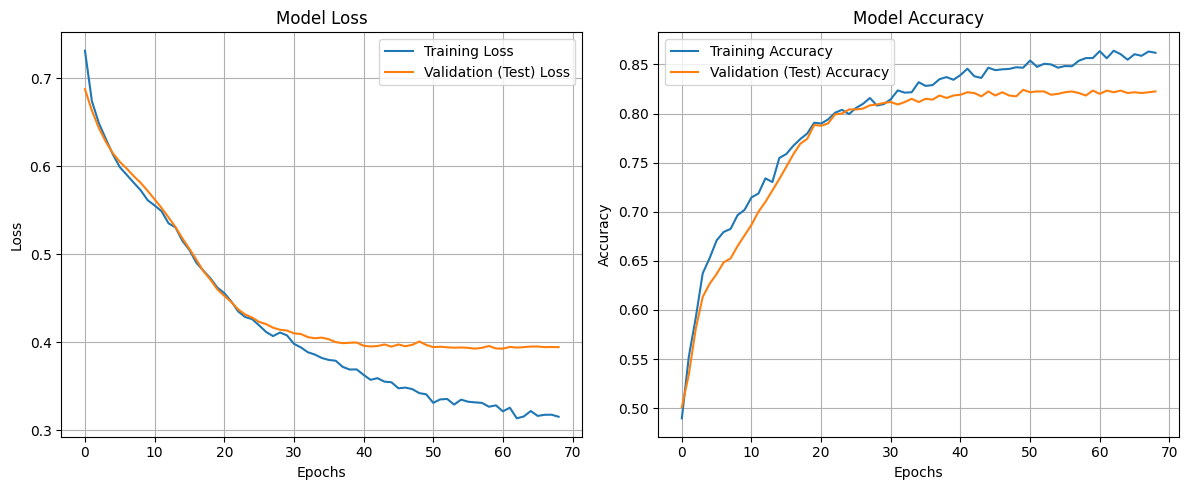

In [57]:
checkpointer = ModelCheckpoint("model_less_layer_fcn-best_weights.keras", verbose=0, save_best_only=True)
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5,         
    patience=5,             
    verbose=1          
)
best_val_loss = float('inf')
best_model = None


model = Sequential()
model.add(Dense(64, input_dim=x_train.shape[1], activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(32, activation='relu'))

model.add(Dense(16, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=SGD(learning_rate=0.01, momentum=0.1), metrics=['accuracy'])
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=12, verbose=2, mode='min', restore_best_weights=True)
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=64, callbacks=[monitor, checkpointer, lr_scheduler], verbose=1, epochs=10000)

#track best model across runs by val loss
val_loss = min(history.history['val_loss'])
print(f"  Run val loss: {val_loss:.4f}")
if val_loss < best_val_loss:
    best_val_loss = val_loss
    best_model = model
    print(f"  New best model (val loss: {best_val_loss:.4f})")

#evaluation
print("\n--- Final Evaluation on Test Set ---")
y_pred_prob = best_model.predict(x_test)
y_pred = (y_pred_prob >= 0.5).astype(int).flatten()
print(classification_report(y_test, y_pred, target_names=['No Sepsis', 'Sepsis']))
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_prob):.4f}")


plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation (Test) Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation (Test) Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## Adam Optimizer - best todo: document

In [58]:
from tensorflow.keras.optimizers import Adam

Epoch 1/10000


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5679 - loss: 0.6401 - val_accuracy: 0.6942 - val_loss: 0.5616
Epoch 2/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7402 - loss: 0.5170 - val_accuracy: 0.7775 - val_loss: 0.4693
Epoch 3/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8166 - loss: 0.4049 - val_accuracy: 0.7933 - val_loss: 0.4490
Epoch 4/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8307 - loss: 0.3779 - val_accuracy: 0.8025 - val_loss: 0.4455
Epoch 5/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8527 - loss: 0.3398 - val_accuracy: 0.8142 - val_loss: 0.4208
Epoch 6/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step - accuracy: 0.8701 - loss: 0.3084 - val_accuracy: 0.8033 - val_loss: 0.4303
Epoch 7/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8666 - loss: 0.3071 - val_accuracy: 0.8150 - val_loss: 0.4177
Epoch 8/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step - accuracy: 0.8776 - loss: 0.2894 - val_accuracy: 0.8

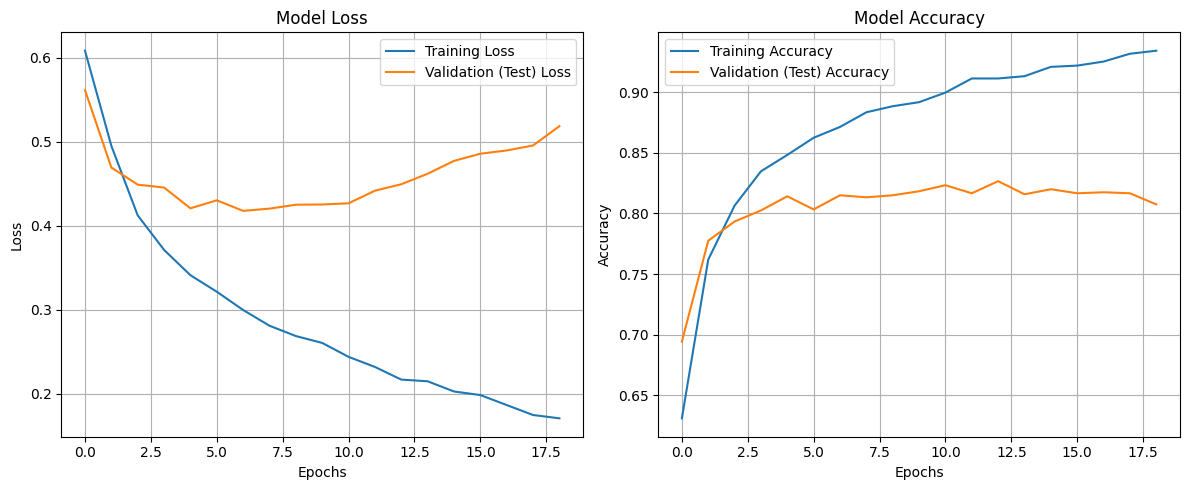

In [72]:
checkpointer = ModelCheckpoint("model_less_layer_fcn-best_weights.keras", verbose=0, save_best_only=True)
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5,         
    patience=5,             
    verbose=1          
)
best_val_loss = float('inf')
best_model = None


model = Sequential()
model.add(Dense(64, input_dim=x_train.shape[1], activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(32, activation='relu'))

model.add(Dense(16, activation='relu'))

model.add(Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=12, verbose=2, mode='min', restore_best_weights=True)
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=64, callbacks=[monitor, checkpointer], verbose=1, epochs=10000)

#track best model across runs by val loss
val_loss = min(history.history['val_loss'])
print(f"  Run val loss: {val_loss:.4f}")
if val_loss < best_val_loss:
    best_val_loss = val_loss
    best_model = model
    print(f"  New best model (val loss: {best_val_loss:.4f})")

#evaluation
print("\n--- Final Evaluation on Test Set ---")
y_pred_prob = best_model.predict(x_test)
y_pred = (y_pred_prob >= 0.5).astype(int).flatten()
print(classification_report(y_test, y_pred, target_names=['No Sepsis', 'Sepsis']))
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_prob):.4f}")


plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation (Test) Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation (Test) Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## Evaluation